#Bioinfo Avancé TP 1 : Phylogénie des gènes de la luciférase

##Introduction
La luciférase est une enzyme (une protéine catalysant une réaction chimique) qui est capable d'émettre de la lumière visible en consommant de l'ATP. On la retrouve dans divers bactéries, lucioles et vers luisants distribués au travers du globe. Nous allons dans ce TP créer un arbre phylogénétique à partir des séquences du gène de la luciférase.


## Exercice 1 : Récupération des données

Pour commencer, et pour se simplifier le travail, nous allons télécharger un ensemble de séquences de luciférases déjà alignées via la base de données pfam.



1. Allez sur http://pfam.xfam.org/
2. Tapez « *Luciferase-like monooxygenase* » dans la barre de recherche.
3. Choisissez l'entrée provenant de la base PFAM (identifiant *PF00296*)
4. Cette page contient un grand nombre d'informations sur la famille protéique de la luciférase. Vous pouvez lire la description pour essayer de mieux comprendre comment celle-ci fonctionne.
5. 5.	Vous trouverez un alignement multiple des différentes séquences de cette famille dans l'onglet « *alignment* » (sur la gauche) et sélectionnez « *seed* » dans le menu déroulant, celui-ci doit posséder 46 séquences.
6. Téléchargez cet alignement.


## Exercice 2 : Préparation des données - construction de la matrice de distances

1. Ouvrez le fichier téléchargé à l'exercice 1 avec un éditeur de texte et comprenez son format.

2. Chargez le fichier et en extraire les identifiants et les séquences.

In [27]:
from pathlib import Path

data_path = Path('PF00296.alignment.seed')
identifiers = []
sequences = []

with data_path.open(encoding='utf-8') as stockholm_file:
    for raw_line in stockholm_file:
        line = raw_line.strip()
        if not line or line.startswith(('#', '//')):
            continue
        seq_id, *seq_chunks = line.split()
        sequence = ''.join(seq_chunks)
        identifiers.append(seq_id)
        sequences.append(sequence)

print(f"{len(identifiers)} séquences chargées depuis {data_path.name}")
print('Identifiants (5 premiers):', identifiers[:5])
print('Longueur de la première séquence:', len(sequences[0]))
print('Extrait de la première séquence:', sequences[0][:80])

46 séquences chargées depuis PF00296.alignment.seed
Identifiants (5 premiers): ['O30260_ARCFU/1-334', 'Q79ZH7_STRAW/38-327', 'SCMK_BACSU/8-364', 'A1K6V6_AZOSB/18-340', 'A6WCN5_KINRD/13-331']
Longueur de la première séquence: 492
Extrait de la première séquence: M........EFGTVAPTFP........................PIEEVPKTAKRMEEKGYDAIWVADHLMGWYPHDLWKE


3. Calculez la distance entre chaque paire de séquence et la stocker dans une matrice de distance.

Cette étape n'est en fait pas triviale et a fait l'objet de beaucoup d'études, en particulier pour essayer de prendre en compte les substitutions multiples pour une position. Pour ce TP nous allons implémenter la distance de Kimura pour protéines provenant du programme [distmat](https://emboss.sourceforge.net/apps/release/6.6/emboss/apps/distmat.html) :

$$
d(s,s') = -\ln(1\ -\ D\ -0.2D^2),
$$

Où $s$,$s'$ sont deux séquences alignées, $D = 1 - S$, $S = m / n$, $m$ le nombre de positions avec des acides aminés identiques et n le nombre de positions contribuant au score (c'est a dire les positions pour lesquelles $s$ et $s'$ ne contiennent pas de trou).

Notez que par définition la matrice de distance est symétrique.

4. Affichez la matrice de distance obtenue en utilisant la fonction *imshow* de matplotlib. Ajoutez aussi une *colorbar* pour avoir une idée des valeurs de distances.

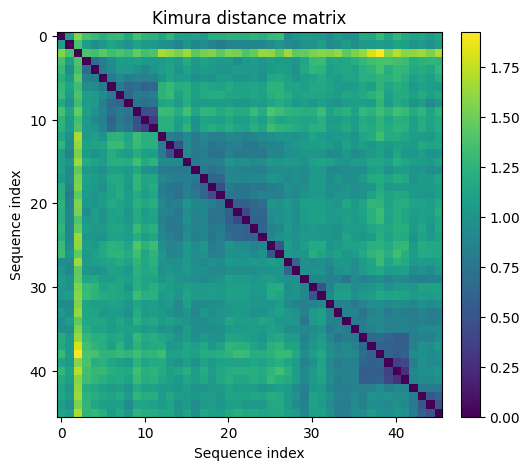

In [28]:
import math

import matplotlib.pyplot as plt
import numpy as np

def kimura_distance(seq_a: str, seq_b: str) -> float:
    matches = 0
    aligned_positions = 0
    for aa, bb in zip(seq_a, seq_b):
        if aa == '-' or bb == '-':
            continue
        aligned_positions += 1
        if aa == bb:
            matches += 1
    if aligned_positions == 0:
        return float('nan')
    S = matches / aligned_positions
    D = 1.0 - S
    term = 1.0 - D - 0.2 * (D ** 2)
    if term <= 0:
        return float('inf')
    return -math.log(term)

n_seq = len(sequences)
distance_matrix = np.zeros((n_seq, n_seq), dtype=float)

for i in range(n_seq):
    for j in range(i + 1, n_seq):
        dist = kimura_distance(sequences[i], sequences[j])
        distance_matrix[i, j] = distance_matrix[j, i] = dist

fig, ax = plt.subplots(figsize=(6, 5))
cax = ax.imshow(distance_matrix, cmap='viridis')
ax.set_title('Kimura distance matrix')
ax.set_xlabel('Sequence index')
ax.set_ylabel('Sequence index')
fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)
plt.show()



##Exercice 3 : Construction d'un arbre phylogénétique via l'algorithme de Neighbour-Joining

1. Implémentez l'algorithme de Neighbour-Joining vu en cours.

In [29]:
import numpy as np

def neighbor_joining(distance_matrix: np.ndarray, labels: list[str]) -> str:
    """Implémente l'algorithme de Neighbour-Joining et retourne l'arbre au format Newick."""
    if distance_matrix.shape[0] != distance_matrix.shape[1]:
        raise ValueError("La matrice de distance doit être carrée.")
    if distance_matrix.shape[0] != len(labels):
        raise ValueError("Le nombre de labels doit correspondre à la matrice de distance.")

    D = distance_matrix.astype(float)
    clusters = labels[:]
    newick_repr = {label: label for label in clusters}
    next_internal = 1

    while len(clusters) > 3:
        n = len(clusters)
        divergence = D.sum(axis=1)
        min_q = None
        pair = None

        for i in range(n - 1):
            for j in range(i + 1, n):
                q_ij = D[i, j] - (divergence[i] + divergence[j]) / (n - 2)
                if min_q is None or q_ij < min_q:
                    min_q = q_ij
                    pair = (i, j)

        i, j = pair
        dij = D[i, j]
        delta_i = 0.5 * dij + (divergence[i] - divergence[j]) / (2 * (n - 2))
        delta_j = dij - delta_i
        delta_i = max(delta_i, 0.0)
        delta_j = max(delta_j, 0.0)

        new_label = f"NJ{next_internal}"
        next_internal += 1
        newick_repr[new_label] = (
            f"({newick_repr[clusters[i]]}:{delta_i:.5f},"
            f"{newick_repr[clusters[j]]}:{delta_j:.5f})"
        )

        keep = [idx for idx in range(len(clusters)) if idx not in (i, j)]
        new_size = len(keep) + 1
        new_D = np.zeros((new_size, new_size))

        for new_row, old_row in enumerate(keep):
            for new_col, old_col in enumerate(keep):
                new_D[new_row, new_col] = D[old_row, old_col]

        for new_idx, old_idx in enumerate(keep):
            dist = 0.5 * (D[i, old_idx] + D[j, old_idx] - dij)
            new_D[new_idx, -1] = new_D[-1, new_idx] = dist

        clusters = [clusters[idx] for idx in keep] + [new_label]
        D = new_D

    # il reste exactement trois groupes
    n = len(clusters)
    assert n == 3, "La routine finale suppose trois clusters restants."
    divergence = D.sum(axis=1)
    i, j, k = 0, 1, 2
    dij = D[i, j]
    delta_i = 0.5 * dij + (divergence[i] - divergence[j]) / (2 * (n - 2))
    delta_j = 0.5 * dij + (divergence[j] - divergence[i]) / (2 * (n - 2))
    delta_k = 0.5 * (D[i, k] + D[j, k] - dij)

    delta_i = max(delta_i, 0.0)
    delta_j = max(delta_j, 0.0)
    delta_k = max(delta_k, 0.0)

    final_subtree = (
        f"({newick_repr[clusters[i]]}:{delta_i:.5f},"
        f"{newick_repr[clusters[j]]}:{delta_j:.5f})"
    )
    final_tree = f"({final_subtree},{newick_repr[clusters[k]]}:{delta_k:.5f});"
    return final_tree


2. calculez l'arbre des sequénces de la luciférase.

In [30]:
import numpy as np

if "distance_matrix" not in globals():
    if "sequences" not in globals():
        raise RuntimeError("Les séquences doivent être chargées avant de construire l'arbre.")
    n_seq = len(sequences)
    distance_matrix = np.zeros((n_seq, n_seq), dtype=float)
    for i in range(n_seq):
        for j in range(i + 1, n_seq):
            dist = kimura_distance(sequences[i], sequences[j])
            distance_matrix[i, j] = distance_matrix[j, i] = dist

luciferase_newick = neighbor_joining(distance_matrix, identifiers)
print(f"Arbre Newick (longueur {len(luciferase_newick)} caractères)")
print(luciferase_newick[:200] + '...')


Arbre Newick (longueur 1689 caractères)
(((Q0RKH1_FRAAA/1-315:0.31999,(Q0RK06_FRAAA/2-307:0.30991,(Q82E53_STRAW/1-300:0.30386,(Q0RK73_FRAAA/5-308:0.22240,Q0RHW5_FRAAA/1-305:0.20984):0.06117):0.04097):0.00433):0.10521,(((Q7M9B5_WOLSU/1-306:0...


##Exercice 4 : Export et visualisation des résultats

Pour visualiser l'arbre obtenu on va le sauvegarder au format newick et utiliser un site pour l'afficher.

1.	Exportez l'arbre au format newick incluant le nom des nœuds et la taille des branches.

In [31]:
from pathlib import Path
import numpy as np

newick_path = Path('luciferase_tree.nwk')

if 'luciferase_newick' not in globals():
    if 'distance_matrix' not in globals():
        if 'sequences' not in globals():
            raise RuntimeError("Chargez d'abord les séquences et calculez la matrice de distance.")
        n_seq = len(sequences)
        distance_matrix = np.zeros((n_seq, n_seq), dtype=float)
        for i in range(n_seq):
            for j in range(i + 1, n_seq):
                dist = kimura_distance(sequences[i], sequences[j])
                distance_matrix[i, j] = distance_matrix[j, i] = dist
    luciferase_newick = neighbor_joining(distance_matrix, identifiers)

newick_path.write_text(luciferase_newick + '\n', encoding='utf-8')
print(f"Fichier Newick sauvegardé dans {newick_path.resolve()}")
print(f"Taille du fichier : {newick_path.stat().st_size} octets")


Fichier Newick sauvegardé dans /home/amthos/document/s9/binfA/BINFA2025_TP1/luciferase_tree.nwk
Taille du fichier : 1690 octets


2. Visualisez votre arbre en uploadant votre résultat sur https://itol.embl.de/tree/

3. En tant que tel, l'arbre n'est pas très instructif. Remplacez les identifiants des noeuds par le nom des espèces correspondantes.

On peut l'obtenir en utilisant pour chaque noeud la première partie de son identifiant (avant le /) qui est reconnaissable par uniprot :
**Q89PP0_BRADU**/1-309

a. Pour recupérer la table d'association, on va d'abord générer la liste de tous ces identifiants avec un identifiant par ligne.

In [32]:
from pathlib import Path

if 'identifiers' not in globals():
    raise RuntimeError("Les identifiants ne sont pas chargés dans l'espace de travail.")

species_ids = sorted({identifier.split('/')[0] for identifier in identifiers})
ids_path = Path('luciferase_uniprot_ids.txt')
ids_path.write_text('\n'.join(species_ids) + '\n', encoding='utf-8')
print(f"{len(species_ids)} identifiants uniques sauvegardés dans {ids_path.resolve()}")
print('Exemple des 5 premiers identifiants :', species_ids[:5])


46 identifiants uniques sauvegardés dans /home/amthos/document/s9/binfA/BINFA2025_TP1/luciferase_uniprot_ids.txt
Exemple des 5 premiers identifiants : ['A0A0H3CX05_AMYMU', 'A0A1U7EVI1_NATPD', 'A0AAF0BQH1_RHOPA', 'A0QPB6_MYCS2', 'A0QZ04_MYCS2']


b. copier-coller cette liste sur le site : https://www.uniprot.org/id-mapping et sauvegarder la table obtenue au format « tsv » en sélectionnant uniquement l'information d'organisme.

c. Utilisez cette table pour remplacer les identifiants des noeuds de l'arbre par les noms d'organismes.

In [ ]:
from __future__ import annotations

import csv
import re
from collections import Counter
from pathlib import Path

mapping_path = Path('idmapping_2025_11_13.tsv')  # <-- adaptez ce nom selon votre fichier téléchargé
species_tree_path = Path('luciferase_tree_species.nwk')

if not mapping_path.exists():
    raise FileNotFoundError(f"Fichier de mapping introuvable : {mapping_path}")
if 'luciferase_newick' not in globals():
    raise RuntimeError("Générez d'abord l'arbre Newick (luciferase_newick).")

with mapping_path.open(encoding='utf-8') as handle:
    reader = csv.DictReader(handle, delimiter='	')
    columns = reader.fieldnames or []
    entry_field = next((c for c in ('From', 'Entry Name', 'Entry') if c in columns), None)
    organism_field = 'Organism' if 'Organism' in columns else None
    if entry_field is None or organism_field is None:
        raise ValueError('Impossible de trouver les colonnes attendues (From/Entry Name, Organism).')
    id_to_species = {row[entry_field].strip(): row[organism_field].strip() for row in reader}

if not id_to_species:
    raise ValueError('Aucune donnée lue dans le fichier de mapping.')

counter = Counter()
label_map: dict[str, str] = {}

for ident in identifiers:
    base_id = ident.split('/')[0]
    species_name = id_to_species.get(base_id)
    if species_name is None:
        raise KeyError(f"Identifiant {base_id} introuvable dans la table UniProt.")
    sanitized = re.sub(r"[^A-Za-z0-9_]+", '_', species_name.strip())
    counter[sanitized] += 1
    suffix = '' if counter[sanitized] == 1 else f'_{counter[sanitized]}'
    label_map[ident] = sanitized + suffix

annotated_newick = luciferase_newick
for raw_label, species_label in label_map.items():
    annotated_newick = annotated_newick.replace(raw_label, species_label)

species_tree_path.write_text(annotated_newick + '\n', encoding='utf-8')
print(f"Nouvel arbre sauvegardé dans {species_tree_path.resolve()}")
print('Exemple de renommage :', next(iter(label_map.items())))


FileNotFoundError: Fichier de mapping introuvable : uniprot_mapping.tsv

d. Visualisez le nouvel arbre